In [29]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from Scattering_Simulator import pairwise_method
from scipy import integrate
import matplotlib.cm as cm
from scipy.spatial.transform import Rotation as R
from gsd import hoomd
from scipy.interpolate import BSpline, splrep
from scipy.signal import savgol_filter
import os
from scipy import integrate

## HOOMD-blue to SAXS without artifacts from Periodic Boundary Conditions 

In this notebook, we address the problem of artifacts in simulated scattering curves arising from periodic bounary conditions and finite-size effects when using the MC-DFM on structures from molecular simulations. We use the method proposed from: 

Tomšič et al., Calculating Small-Angle X-Ray Scattering Intensities from Monte Carlo Results: Exploring Different Approaches on the Example of Primary Alcohols. (2007) 

The paper addresses the problem of periodic boundary conditions and finite-size effects — particularly artificial background scattering — when calculating small-angle X-ray scattering (SAXS) curves from finite simulation boxes using the Debye equation. Direct application of the Debye equation to a single simulation box introduces artifacts due to sharp boundaries and periodicity. To solve this, the authors propose a method where multiple sub-boxes of varying sizes are extracted from a replicated superbox, and their individual scattering curves are combined using optimized weights. These weights are determined by fitting a linear combination of scattering curves from homogeneous reference cubes to a physical q^-4 Porod decay, effectively removing box-size artifacts and recovering physically meaningful SAXS behavior.

We will use the same structure from the HOOMD Spheres notebook. We first extract the structure of the spheres in the simulation using the same code from the other notebook. 

In [30]:
def extract_positions_orientations(filename):
    """
    Extract positions and orientations from each frame of a GSD file.

    Parameters
    ----------
    filename : str
        Path to the GSD trajectory file.

    Returns
    -------
    positions : list of np.ndarray
        List of arrays of shape (N, 3) with particle positions per frame.
    orientations : list of np.ndarray or None
        List of arrays of shape (N, 4) with quaternions per frame,
        or None if not present in the frame.
    """
    traj = hoomd.open(name=filename, mode='r')

    positions = []
    orientations = []

    for frame in traj:
        positions.append(frame.particles.position.copy())

        if hasattr(frame.particles, 'orientation'):
            orientations.append(frame.particles.orientation.copy())
        else:
            orientations.append(None)

    return positions, orientations


def quaternion_to_euler(quat, degrees=True, order='xyz'):
    """
    Convert a quaternion (HOOMD format: [qw, qx, qy, qz]) to Euler angles.

    Parameters:
    - quat: array-like, quaternion [qw, qx, qy, qz]
    - degrees: bool, return angles in degrees if True (default), radians if False
    - order: str, axes sequence for Euler angles ('xyz', 'zyx', etc.)

    Returns:
    - tuple of 3 Euler angles (angle_x, angle_y, angle_z)
    """
    # Convert to scipy format (qx, qy, qz, qw)
    #scipy_quat = [quat[1], quat[2], quat[3], quat[0]]
    scipy_quat = quat
    r = R.from_quat(scipy_quat)
    angles = r.as_euler(order, degrees=degrees)
    return angles

In [31]:
file_path = '../Data/HOOMD/spheres_assembly/sphere_assembly_density_0.05.gsd' #This is the path to the .gsd file 

In [32]:
positions, orientations = extract_positions_orientations(file_path)
print(f"Number of frames: {len(positions)}")
print("First frame position shape:", positions[0].shape)
print("First frame orientation shape:", orientations[0].shape if orientations[0] is not None else "Not available")

Number of frames: 200
First frame position shape: (5000, 3)
First frame orientation shape: (5000, 4)


In [33]:
orientations_euler = []
for i in range(len(orientations)):
    angles = quaternion_to_euler(orientations[i][:, :]) 
    orientations_euler.append(angles)

lattice_coordinates = []
for i in range(len(orientations_euler)):
    lattice_coordinates.append(np.hstack((positions[i][:, :], orientations_euler[i][:, :])))

In [34]:
lattice_coordinates = lattice_coordinates[-1]

## Building Block 
The building block is defined as the object being simulated such as a sphere or cube. This is not saved in the .gsd file so we need to create this object here. 

In [35]:
def grid_points_in_sphere(D, spacing):
    """
    Generate a regular 3D grid of points spaced by 'spacing' that fit inside a sphere.

    Parameters
    ----------
    D : float
        Diameter of the sphere.
    spacing : float
        Distance between adjacent grid points.

    Returns
    -------
    points : np.ndarray of shape (M, 3)
        Grid points inside the sphere.
    """
    radius = D / 2.0
    r2 = radius ** 2

    # Create a 3D grid
    coords = np.arange(-radius, radius + spacing, spacing)
    X, Y, Z = np.meshgrid(coords, coords, coords)
    grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Keep only the points inside the sphere
    mask = np.sum(grid**2, axis=1) <= r2
    points = grid[mask]

    return points

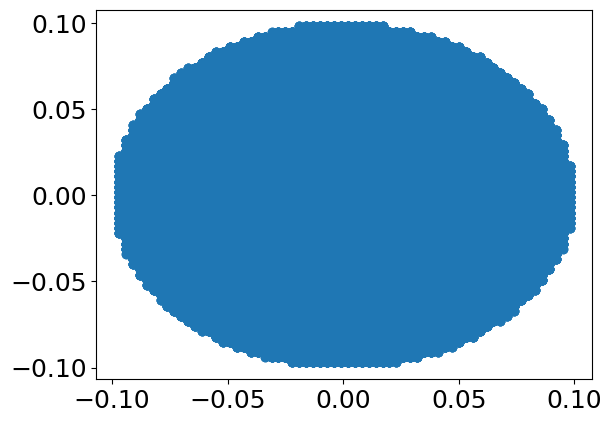

In [42]:
#Sphere
D = 0.2            # diameter of the sphere
spacing = 0.003    # spacing between grid points
points = grid_points_in_sphere(D, spacing)

#Cube
#points = fill_cube_with_points(N=100000, edge_length=0.1)

ones = np.array([1]*len(points))
points = np.hstack((points, ones.reshape(-1,1)))
plt.scatter(points[:,0], points[:,2])
plt.show()

## Calculate the Scattering curve 

First, a large superbox is created by replicating the original simulation box, allowing the extraction of cubic sub-boxes of varying sizes without including artificial boundary effects. Each sub-box contains a realistic configuration of particles and is used to compute a SAXS curve with the MC-DFM, which accounts for all pairwise distances within the sub-box.

Simulation of Subbox  0 / 8 complete ...
Simulation of Subbox  1 / 8 complete ...
Simulation of Subbox  2 / 8 complete ...
Simulation of Subbox  3 / 8 complete ...
Simulation of Subbox  4 / 8 complete ...
Simulation of Subbox  5 / 8 complete ...
Simulation of Subbox  6 / 8 complete ...
Simulation of Subbox  7 / 8 complete ...
Simulation of Subbox  8 / 8 complete ...


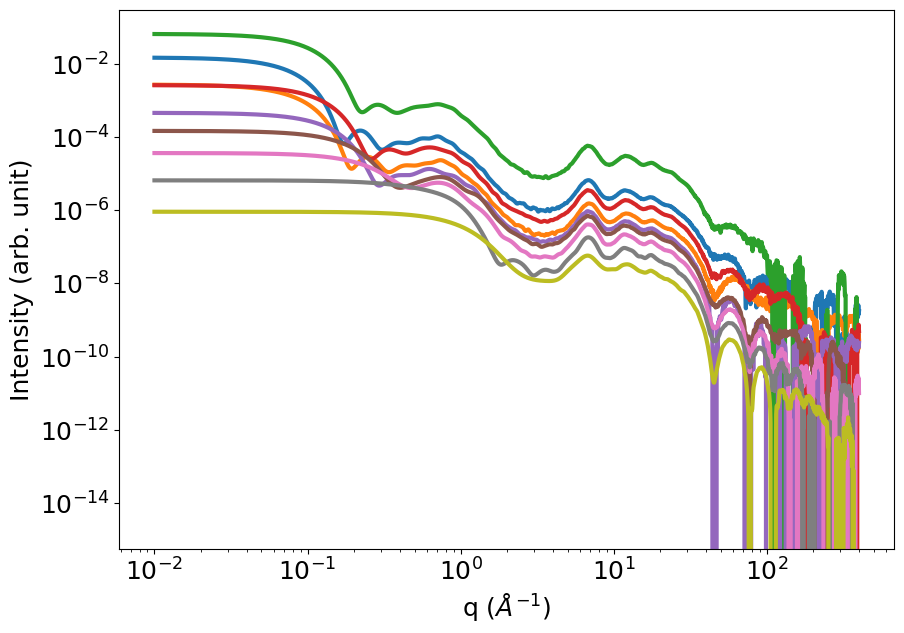

In [43]:
################################## INPUTS ##########################################################################################
box_length_simulation = (5000/0.05)**(1/3)
histogram_bins = 10000            # Number of bins in the pairwise distribution calculation 
q = np.geomspace(0.01, 400, 2000)  # SAXS q-range to be calculated
sub_box_fraction = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
plot = True
####################################################################################################################################
data = pairwise_method.calculate_scattering_curve_with_PCB(lattice_coordinates, points, box_length_simulation, histogram_bins, q, sub_box_fraction, plot)

Different-sized sub-boxes contribute differently to the overall intensity due to their varying volumes and particle counts, which inherently scale the raw SAXS intensities. To avoid this size bias, idealized homogeneous cubes (filled with uniform scattering density) are also generated for the same set of side lengths as the sub-boxes. The normalized form factors of these ideal cubes, which decay smoothly as q^-4 due to Porod's law, are used to fit a power-law envelope in the high-q regime, yielding a set of weights that represent how much each box size contributes to reproducing the expected physical background. 

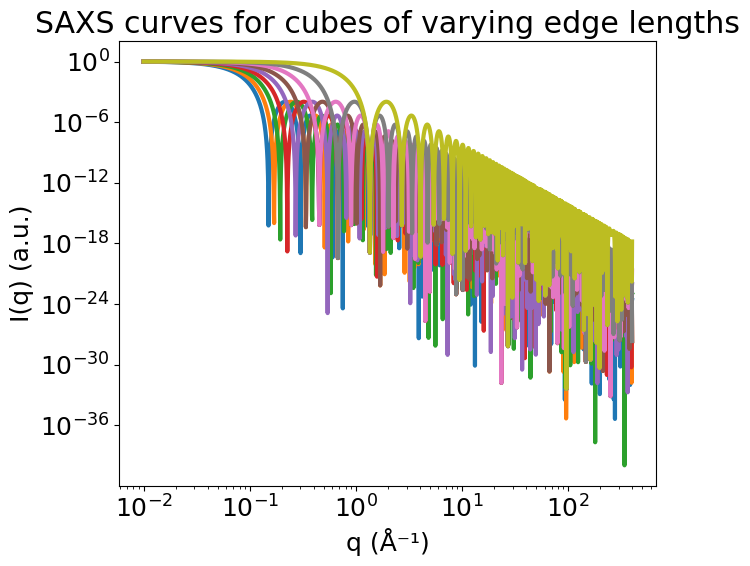

In [44]:
plt.figure(figsize=(7, 6))
cube_Iq = []
for i in range(len(sub_box_fraction)):
    Iq = pairwise_method.cube_form_factor(q, sub_box_fraction[i]*box_length_simulation)
    cube_Iq.append(Iq)
    plt.loglog(q, Iq, linewidth=3)

plt.xlabel("q (Å⁻¹)")
plt.ylabel("I(q) (a.u.)")
plt.title("SAXS curves for cubes of varying edge lengths")
plt.tight_layout()
plt.show()

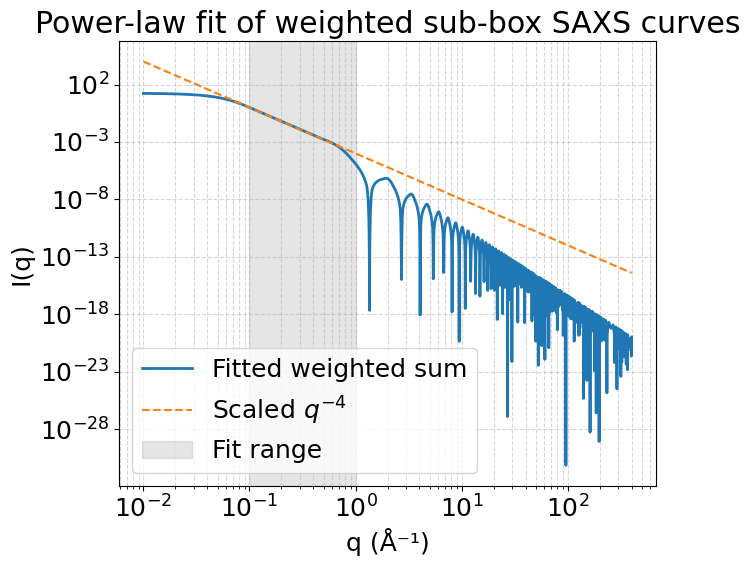

In [45]:
weights, I_fit, power_law = pairwise_method.fit_subbox_saxs_to_power_law(q, cube_Iq, 0.1, 1, power=-4, plot=True)

These weights are then applied to the real scattering curves from the simulation sub-boxes but only after those curves are normalized by their particle pair count or volume squared. This normalization ensures that each sub-box contributes comparably on a per-structure basis, and that the final weighted average reflects only the physically meaningful features of the system’s structure, free from box-size artifacts. The result is a SAXS curve that mimics what would be observed from an infinitely large, homogeneous sample with correct high-decay and no artificial oscillations introduced by the simulation box boundaries.

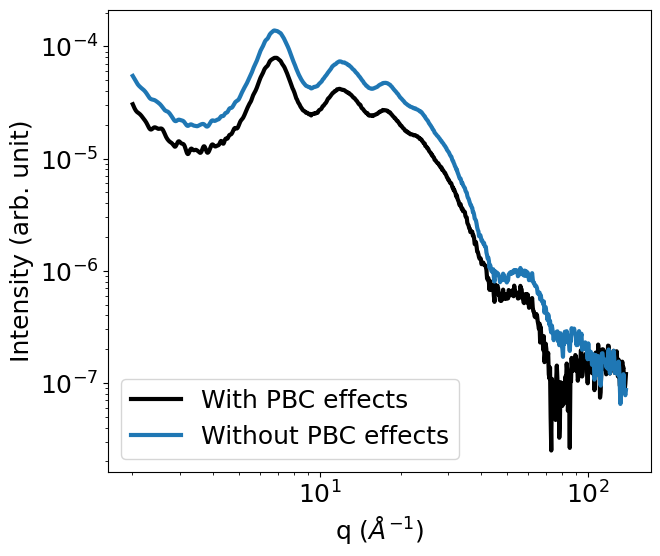

In [46]:
Iq_array = np.vstack(data)
Iq_fit = np.dot(weights, Iq_array)
fig, ax = plt.subplots(figsize=(7,6))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Intensity (arb. unit)')
ax.set_xlabel('q ($\\AA^{-1}$)')
lower = 1000
upper = -200
ax.plot(q[lower:upper], data[0][lower:upper]*1.2e1, color='k', linewidth = 3, label ='With PBC effects')
ax.plot(q[lower:upper], Iq_fit[lower:upper], color='C0', linewidth = 3, label='Without PBC effects')
#plt.show()
plt.legend()
#plt.savefig('../Images/simulation_saxs_curves_PBC.png', dpi=600, bbox_inches="tight")